In [ ]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="./style_transfer_dataset")

In [2]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4913
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1235
    })
})

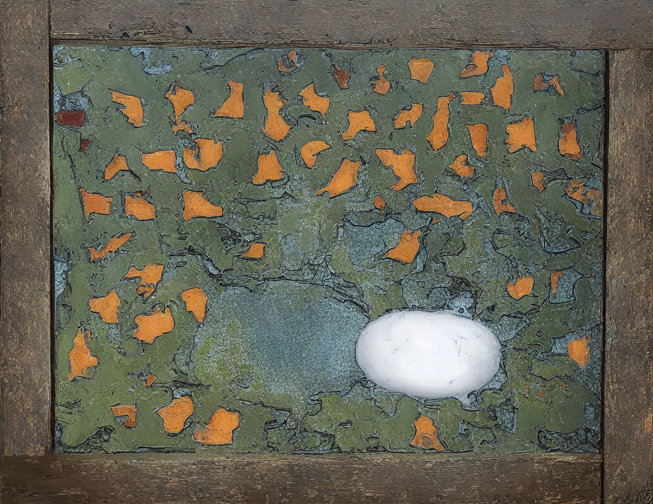

In [3]:
dataset['train'][1]['image']

In [4]:
labels = dataset['train'].features['label']
labels

ClassLabel(names=['generated', 'original'], id=None)

In [5]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

def transform(batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = image_processor([x for x in batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['label'] = batch['label']
    return inputs

dataset = dataset.with_transform(transform)

In [6]:
dataset['train'][0]['pixel_values'].shape

torch.Size([3, 224, 224])

In [7]:
from torch.utils.data import DataLoader

import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

dataloader = DataLoader(dataset["train"], collate_fn=collate_fn, batch_size=8, shuffle=True)

In [ ]:
from transformers import AutoModelForImageClassification

labels = dataset['train'].features['label'].names

model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224",
                                                        num_labels=len(labels),
                                                        id2label={str(i): c for i, c in enumerate(labels)},
                                                        label2id={c: str(i) for i, c in enumerate(labels)},
                                                        ignore_mismatched_sizes=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

In [10]:
from tqdm.notebook import tqdm

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

model.train()
for epoch in range(4):
  print("Epoch:", epoch)
  correct = 0
  total = 0
  for idx, batch in enumerate(tqdm(dataloader)):
    # move batch to GPU
    batch = {k:v.to(device) for k,v in batch.items()}

    optimizer.zero_grad()

    # forward pass
    outputs = model(pixel_values=batch["pixel_values"],
                    labels=batch["labels"])
    
    loss, logits = outputs.loss, outputs.logits
    loss.backward()
    optimizer.step()

    # metrics
    total += batch["labels"].shape[0]
    predicted = logits.argmax(-1)
    correct += (predicted == batch["labels"]).sum().item()

    accuracy = correct/total

    if idx % 100 == 0:
      print(f"Loss after {idx} steps:", loss.item())
      print(f"Accuracy after {idx} steps:", accuracy)

Epoch: 0


  0%|          | 0/615 [00:00<?, ?it/s]

Loss after 0 steps: 0.7095649838447571
Accuracy after 0 steps: 0.625
Loss after 100 steps: 0.16105614602565765
Accuracy after 100 steps: 0.9034653465346535
Loss after 200 steps: 0.007058197632431984
Accuracy after 200 steps: 0.9334577114427861
Loss after 300 steps: 0.0032723480835556984
Accuracy after 300 steps: 0.9476744186046512
Loss after 400 steps: 0.001440616324543953
Accuracy after 400 steps: 0.9560473815461347
Loss after 500 steps: 0.0021674970630556345
Accuracy after 500 steps: 0.9615768463073853
Loss after 600 steps: 0.0027292536105960608
Accuracy after 600 steps: 0.9650582362728786
Epoch: 1


  0%|          | 0/615 [00:00<?, ?it/s]

Loss after 0 steps: 0.001256337040103972
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.0004707284679170698
Accuracy after 100 steps: 0.9876237623762376
Loss after 200 steps: 0.0001235215167980641
Accuracy after 200 steps: 0.9919154228855721
Loss after 300 steps: 0.009885327890515327
Accuracy after 300 steps: 0.9916943521594684
Loss after 400 steps: 0.0003849858185276389
Accuracy after 400 steps: 0.9928304239401496
Loss after 500 steps: 0.007475920487195253
Accuracy after 500 steps: 0.9912674650698603
Loss after 600 steps: 0.0001508045825175941
Accuracy after 600 steps: 0.9920965058236273
Epoch: 2


  0%|          | 0/615 [00:00<?, ?it/s]

Loss after 0 steps: 9.277896606363356e-05
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.0007532637100666761
Accuracy after 100 steps: 0.995049504950495
Loss after 200 steps: 0.0003456611302681267
Accuracy after 200 steps: 0.9975124378109452
Loss after 300 steps: 0.00032820459455251694
Accuracy after 300 steps: 0.9983388704318937
Loss after 400 steps: 0.0005308945546858013
Accuracy after 400 steps: 0.996571072319202
Loss after 500 steps: 0.00011072215420426801
Accuracy after 500 steps: 0.9970059880239521
Loss after 600 steps: 0.028846168890595436
Accuracy after 600 steps: 0.9962562396006656
Epoch: 3


  0%|          | 0/615 [00:00<?, ?it/s]

Loss after 0 steps: 0.00022066448582336307
Accuracy after 0 steps: 1.0
Loss after 100 steps: 8.747649553697556e-05
Accuracy after 100 steps: 0.9987623762376238
Loss after 200 steps: 4.671265560318716e-05
Accuracy after 200 steps: 0.9987562189054726
Loss after 300 steps: 0.00861884094774723
Accuracy after 300 steps: 0.9958471760797342
Loss after 400 steps: 4.3687858124030754e-05
Accuracy after 400 steps: 0.9959476309226932
Loss after 500 steps: 0.018379606306552887
Accuracy after 500 steps: 0.9962574850299402
Loss after 600 steps: 0.00046672322787344456
Accuracy after 600 steps: 0.9962562396006656


In [11]:
dataloader_test = DataLoader(dataset["test"], collate_fn=collate_fn, batch_size=1, shuffle=True)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:

model.push_to_hub("VaggP/vit-base-finetuned-for-style-transfer-in-art-detection")


In [ ]:
image_processor.push_to_hub("VaggP/vit-base-finetuned-for-style-transfer-in-art-detection")